### Project: Analyze fluctuations in HTTP request latency data to determine reliability

- Load data (.csv) to dataframe
- Standardize and cleaning data
- Expore data
- Analyze data:
    ABC
- Apply model

In [122]:
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy as np

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
pd.options.mode.chained_assignment = None

In [151]:
FIG_SIZE = (20, 4)

In [123]:
# Load dataset from CSV file
root_df = pd.read_csv('../statics/csv/raw_data-2024-02-20_14_18_06.csv')

Dataset là những dữ liệu thời gian thực (time-series data) liên quan đến thông tin độ trễ (latency) từ người dùng truy cập dịch vụ.

**Details:**

*Dữ liệu là các metrics được trích xuất từ Prometheus. Metrics này liên quan đến thông tin request từ client được gửi tới Proxy. Các Exporter collect metrics từ proxy và đẩy nó về Prometheus database.* 

### Standardize and cleaning data

In [124]:
# Clean data
# Select related columns
cols = root_df.columns.to_list()
colums_drop = []
for col in cols:
    num_row = root_df.drop_duplicates(subset=col).__len__()
    if num_row == 1:
        colums_drop.append(col)
# Show columns will be drop
root_df = root_df.drop(columns=colums_drop) # Only select column selected
# Rename columns
cols_rename_dict = {
    "Time": "timestamp",
    "Value": "value"
}
root_df = root_df.rename(columns=cols_rename_dict)
# Change datetime format for column "timestamp" and timezone
root_df['timestamp'] = pd.to_datetime(root_df["timestamp"], unit="ms", utc=True).map(lambda x: x.tz_convert('Asia/Ho_Chi_Minh'))
root_df.head()

,timestamp,controller_pod,instance,kubernetes_node,kubernetes_pod_name,le,method,status,value
0,2024-02-20 12:00:00+07:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,inf,DELETE,308,13
1,2024-02-20 12:00:30+07:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,inf,DELETE,308,13
2,2024-02-20 12:01:00+07:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,inf,DELETE,308,13
3,2024-02-20 12:01:30+07:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,inf,DELETE,308,13
4,2024-02-20 12:02:00+07:00,ingress-nginx-controller-browser-prod-6667d78f...,172.16.16.96:10254,br-ingress2v.itim.vn,ingress-nginx-controller-browser-prod-6667d78f...,inf,DELETE,308,13


Trên đây dataset liên quan đến thống kê truy cập từ client sau khi thông qua các bước clean và standardilize. Thông tin các cột xuất hiện trong bảng dữ liệu:
- timestamp: Dấu thời gian, biểu thị số liệu tại thời điểm đó
- le: Latency, các buckets latency (hay còn gọi là các bins theo cách gọi của histogram).
- status: HTTP status return by service
- method: HTTP method
- value: Giá trị của latency tại thời điểm timestamp, nó sẽ luôn luôn tăng (counter) vì toàn bộ số lượng request gửi tới server từ trước tới nay luôn luôn tăng chứ không giảm.

*Note*

- Dữ liệu trên được scrape từ Proxy sau mỗi 30 seconds (interval=50s) và được aggregate trong thời gian đó, vì vậy timestamp luôn luôn có delta_t = 50s.
- Việc lưu thông tin về request liên quan đến latency sử dụng các buckets để thống kê giúp cho việc giảm thiểu tài nguyên lưu trữ thay vì lưu lại duration_time cho mỗi request cụ thể. Vì vậy nó giúp cho việc overview tình trạng latency service hiệu quả hơn (dễ dàng overview bằng histogram). Tuy nhiên, sẽ phải đánh đổi về độ chính xác của metrics, đặc biệt là khi có những request có latency cực cao hoặc cực thấp thì histogram sẽ không phản ánh rõ được điều đó. <<Cho ví dụ>>

### RATE

In [125]:
# Get all group (maybe call legends) in dataset
legend_labels = ["controller_pod", "instance", "kubernetes_node", "kubernetes_pod_name", "le", "method", "status"]
legends = root_df.groupby(legend_labels).first().reset_index()[legend_labels]

In [126]:
# Simulator rate by freq
FREQ_RATE = "5min"

arr_df_rate = []
for idx, el in legends.iterrows():
    sample = root_df[(root_df['status'] == el['status'])
                     & (root_df['instance'] == el['instance'])
                     & (root_df['controller_pod'] == el['controller_pod'])
                     & (root_df['kubernetes_node'] == el['kubernetes_node'])
                     & (root_df['kubernetes_pod_name'] == el['kubernetes_pod_name'])
                     & (root_df['le'] == el['le'])
                     & (root_df['method'] == el['method'])].groupby([pd.Grouper(key="timestamp", freq=FREQ_RATE)])[legend_labels + ["value"]].first()
    # Calculate rate()
    sample['rate'] = sample['value'].diff(
    ) / sample.index.to_series().diff().dt.total_seconds()
    arr_df_rate.append(sample)
df_rate_freq = pd.concat(arr_df_rate)
# Drop first row having NaN value in rate
df_rate_freq = df_rate_freq.dropna()
df_rate_freq.describe()


,le,status,value,rate
count,29700.00000,29700.000000,2.970000e+04,28512.000000
mean,inf,381.363636,3.085256e+06,0.368646
std,NaN,105.224427,1.449980e+07,2.031546
min,0.00500,200.000000,0.000000e+00,0.000000
25%,0.04375,308.000000,1.100000e+01,0.000000
50%,0.37500,404.000000,8.125000e+02,0.000000
75%,3.12500,499.000000,3.304025e+04,0.000000
max,inf,504.000000,9.582152e+07,16.140000


Để ý kết quả của mốc thời gian đầu tiên có giá trị rate = NaN bởi vì tập dữ liệu được xuất ra đang không có dữ liệu từ 2024-02-16 06:00:00 trở về trước. Đối với trường hợp này chỉ đơn giản là drop dòng đầu tiên có giá trị NaN và xét đến dòng tiếp theo (thực hiện xét trong khoảng thời gian từ 2024-02-16 06:05:00)

### CALCULATE SUM(RATE)

In [129]:
df_sum_rate = pd.DataFrame()
df_sum_rate['rate'] = df_rate_freq.groupby(['timestamp', 'le'])['rate'].sum()
df_sum_rate = df_sum_rate.reset_index()

### HISTOGRAM QUANTILE

In [130]:
def histogram_quantile(percentiles: float, df: pd.DataFrame):
    # Choice columns for calculate
    columns = ["le", "rate"]
    df = df[columns].reset_index(drop=True)
    # Get count
    count = df[df['le'] == np.Inf]['rate'].item()
    rank = count * percentiles
    df['delta_rate'] = df['rate'].diff()
    df.loc[0, 'delta_rate'] = df.loc[0, 'rate'] # Fill NaN value is first value of rate
    count, upper_idx, lower_idx = 0, 0, 0
    for idx, val in df['delta_rate'].items():
        count = count + val
        upper_idx = idx
        lower_idx = idx - 1
        if count >= rank:
            break
    
    # Get specify row by index
    range = df[(df.index == upper_idx) | (df.index == lower_idx)]
    points = []
    for idx, row in range.iterrows():
        point = (row['rate'], row['le'])
        points.append(point)
    # Check if point contains +Inf -> select lower
    y = [point[-1] for point in points]
    if np.Inf in y:
        return range['le'][lower_idx]
    
    # Using Linear interpolation
    y1 = points[0][-1]
    y2 = points[1][-1]
    x = rank
    x1 = points[0][0]
    x2 = points[1][0]

    return y1 + (x-x1)*(y2 - y1)/(x2-x1)

In [131]:
percentile = 0.75

# Get distinct timestamp
timestamps = df_sum_rate['timestamp'].drop_duplicates().to_list()
# Create df histogram percentile
histogram_percentile_values = []
for timestamp in timestamps:
    sample = df_sum_rate[df_sum_rate['timestamp'] == timestamp]
    percentile_value = histogram_quantile(percentile, sample)
    val = {
        "timestamp": timestamp,
        "value": percentile_value
    }
    histogram_percentile_values.append(val)
df_histogram_percentile = pd.DataFrame(histogram_percentile_values)
df_histogram_percentile.head()

,timestamp,value
0,2024-02-20 12:05:00+07:00,0.007837
1,2024-02-20 12:10:00+07:00,0.007925
2,2024-02-20 12:15:00+07:00,0.007068
3,2024-02-20 12:20:00+07:00,0.007595
4,2024-02-20 12:25:00+07:00,0.007341


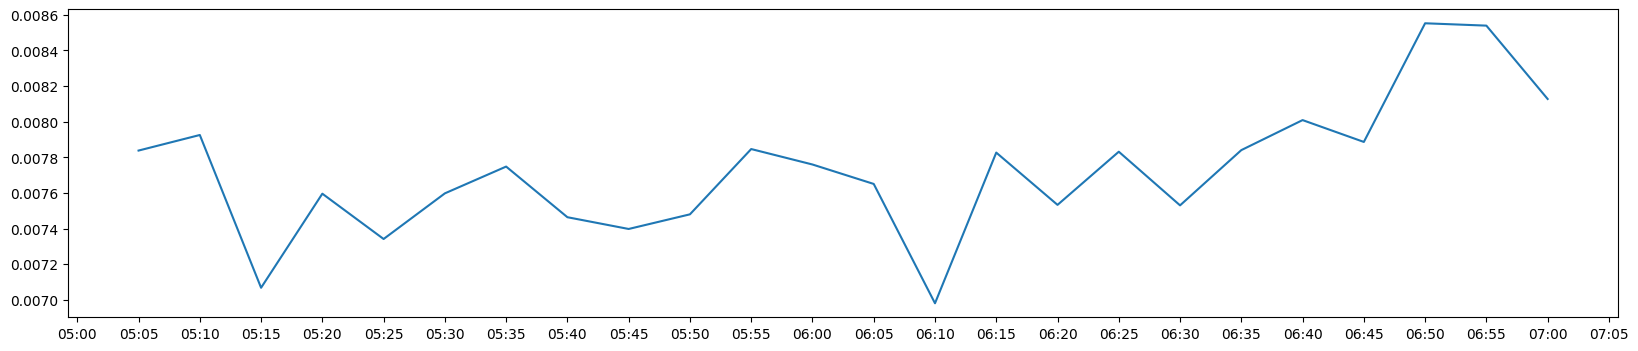

In [132]:
# Plot
import matplotlib.dates as mdates
fig, ax = plt.subplots(figsize=(20, 4))
ax.xaxis.set_major_locator(mdates.MinuteLocator(byminute=[x*5 for x in range(12)]))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.plot(df_histogram_percentile['timestamp'], df_histogram_percentile['value'])
plt.show()
# df_histogram_percentile.plot()

#### SAMPLE (Calculate histogram quantile)

### Explore data

Đầu tiên sẽ thực hiện khám phá dataset đang xét xem có điều gì bất thường đối với tập dữ liệu đó không. Bởi dataset trên đang sử dụng cho mục đích phân tích dữ liệu liên quan đến latency của service. Nên giá trị cần lưu ý trong tập dữ liệu trên là **timestamp và value** sẽ ưu tiên để đánh giá những bất thường. 

Thực hiện vẽ biểu đồ đánh giá tổng quan theo time-series để xem xét việc tăng trưởng request đối với hệ thống

<Axes: xlabel='timestamp'>

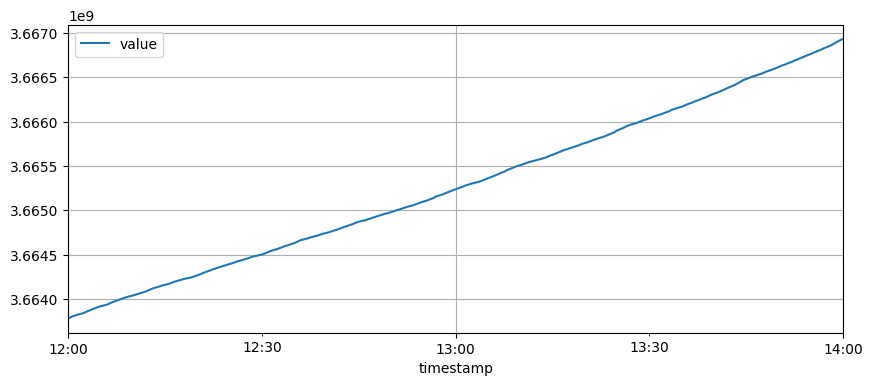

In [133]:
root_df.groupby(['timestamp']).agg({'value': 'sum'}).reset_index().set_index("timestamp").sort_index().plot(figsize=(10, 4), grid=True)

Có vẻ có bất thường gì đó đối với dataset. Quan sát thấy ngưỡng thời gian trong khoảng từ [7:25 -> 7:28] số lượng request tăng vọt. Vậy vấn đề ở đây là gì?

In [134]:
timerange_abnormal = ["2024-02-05 07:25:00", "2024-02-05 07:28:00"]
mask = (root_df['timestamp'] > timerange_abnormal[0]) & (root_df['timestamp'] <= timerange_abnormal[1])
data_abnormal = root_df.loc[mask].reset_index(drop=True)
data_abnormal.head()

,timestamp,controller_pod,instance,kubernetes_node,kubernetes_pod_name,le,method,status,value


<Axes: xlabel='timestamp'>

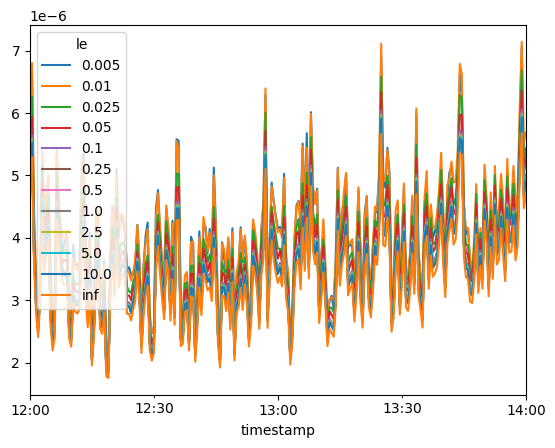

In [135]:
data_abnormal_agg_le = root_df.groupby(['timestamp', 'le']).agg({'value': 'sum'}).reset_index()
data_abnormal_agg_le['pct_change'] = data_abnormal_agg_le.groupby(['le'])['value'].pct_change()
data_abnormal_agg_le.pivot(index="timestamp", columns="le", values="pct_change").plot()